# Detecting malicious URLs
Some introduction...

## Data exploration and cleaning

### General dataset information

In [1]:
DATASET_PATH = 'datasets/malicious_urls.csv'

In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv(DATASET_PATH)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651191 entries, 0 to 651190
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     651191 non-null  object
 1   type    651191 non-null  object
dtypes: object(2)
memory usage: 9.9+ MB


In [3]:
df.describe()

,url,type
count,651191,651191
unique,641119,4
top,http://style.org.hc360.com/css/detail/mysite/s...,benign
freq,180,428103


In [4]:
df.type.value_counts()

benign        428103
defacement     96457
phishing       94111
malware        32520
Name: type, dtype: int64

In [5]:
# Remove duplicates
df.drop_duplicates(inplace=True, subset=['url'], keep='last')
count = df.type.value_counts()
count

benign        428074
defacement     95308
phishing       94092
malware        23645
Name: type, dtype: int64

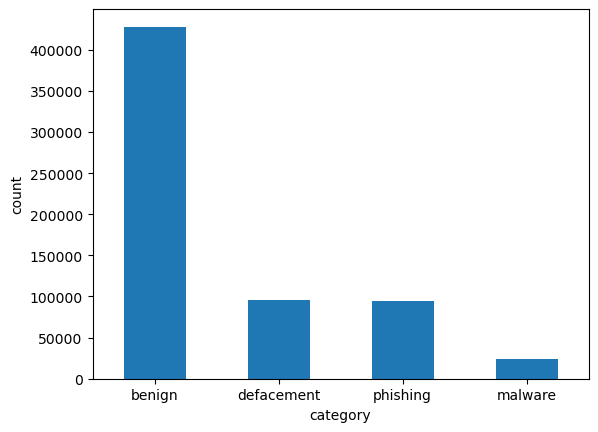

In [6]:
import matplotlib.pyplot as plt
count.plot.bar()
plt.xticks(rotation=0)
plt.xlabel("category")
plt.ylabel("count")
plt.show()

### Character encoding

In [7]:
# Detect character encoding
import chardet

encodings = df['url'].apply(lambda x: chardet.detect(str(x).encode('utf-8')))
df['encoding'] = encodings.apply(lambda x: x['encoding'])
df['enc_confidence'] = encodings.apply(lambda x: x['confidence'])

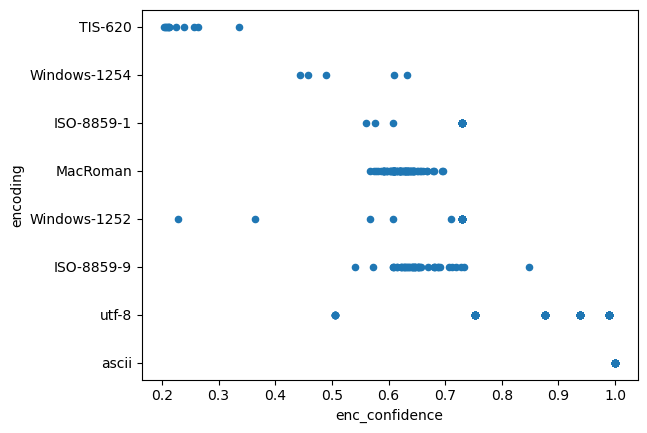

In [8]:
enc_df = pd.DataFrame(df[['encoding', 'enc_confidence']])
enc_df['encoding'] = enc_df['encoding'].apply(lambda x: str(x))
enc_df.drop(enc_df[enc_df.encoding == 'None'].index, inplace=True)
enc_df.plot.scatter(y = 'encoding', x = 'enc_confidence')
 
plt.show()

In [9]:
# By trying some queries we observe that there are some URL strings with broken encoding
df.query(expr='encoding not in ("ascii" , "utf-8")')

,url,type,encoding,enc_confidence
4491,citizendia.org/Agence_métropolitaine_de_transport,benign,ISO-8859-9,0.629187
7564,wn.com/HYMNE_NATIONAL_DU_QUÉBEC,benign,Windows-1252,0.730000
8116,forum.verygames.net/showthread.php?42812-Probl...,benign,MacRoman,0.635195
14053,dictionary.sensagent.com/jehane+benoît/fr-fr/,benign,ISO-8859-9,0.682751
14853,dictionary.sensagent.com/université+de+sherbro...,benign,MacRoman,0.621045
...,...,...,...,...
573492,ÆÖY'uEdS*Z£ñ>7ñV\pìnY÷¡ß¬á'×?...,phishing,TIS-620,0.210592
573495,ùAyéTôDpFc~h@^¶\øâèû¥ÊÞG·ê(Tøì\0«Y=D ...,phishing,None,0.000000
573499,=Rãmôj³{è!ÀM¶6<N>w ¼Cf£]4ÍnÝÌ,phishing,None,0.000000
573507,«Düéºþ +ZIdN Ö-lh9L©hDKÄúhßÆ%YqÃ±¹d,phishing,None,0.000000


In [10]:
# Attempt to fix some broken encoding
from ftfy import fix_encoding

df_fixed = pd.DataFrame()
df_fixed['url'] = df['url']
df_fixed['url_fixed'] = df_fixed['url'].apply(fix_encoding)
df_fixed.query(expr='url != url_fixed')

,url,url_fixed
44274,zoominfo.com/people/de%20GrandprÃ©_Jean_344774...,zoominfo.com/people/de%20Grandpré_Jean_3447745...
61961,http://www.scsrxx.com/js/?https://secure.runes...,http://www.scsrxx.com/js/?https://secure.runes...
126643,zoominfo.com/people/Sagan_FranÃƒÆ’Ã‚Â§oise_147...,zoominfo.com/people/Sagan_Françoise_1473040483...
300255,castroller.com/podcasts/CanaluPodcasts3/128646...,castroller.com/podcasts/CanaluPodcasts3/128646...
360359,zoominfo.com/people/SÃ©vigny_Danielle_15449882...,zoominfo.com/people/Sévigny_Danielle_154498825...
...,...,...
573506,r $ÐcYõ,r $Ðc˜‚Yõ
573507,«Düéºþ +ZIdN Ö-lh9L©hDKÄúhßÆ%YqÃ±¹d,«Dü‘éºþ +ZIdN Ö-lh9L©hŽDKÄúhßÆ%Yqñ¹d
573508,Þ~³\(ÿÇ½Jú$Xm £ÜëÃ5{¾kÜãCê_QÊ©B ÇÈc2...,އ~³„Ÿ\(ÿǽJú$Xm £ÜëÃ5{¾kÜãCê_QÊ©B…ǆÈc2#S...
573509,"ëËl×uÏB'JI¨GÙn""Ç( 0","ëËl×uÏB'JI¨GÙn""Ç(…0"


In [11]:
# Commit changes and check for strings that are still broken
df['url'] = df_fixed['url_fixed']
df.query('enc_confidence < 0.5')    # Includes all unidentified encodings

,url,type,encoding,enc_confidence
573417,esxcc.com/js/index.htm?us.battle.net/noghn/en/...,phishing,None,0.000000
573418,wwweira¯&nvinip¿ncH¯wVö%ÆåyDaHðû/ÏyEùuË\nÓ6...,phishing,None,0.000000
573422,ruta89fm.com/images/AS@Vies/1i75cf7b16vc<Fd16...,phishing,TIS-620,0.264226
573424,esxcc.com/js/index.htm?us.battle.net/login/en/...,phishing,Windows-1254,0.490066
573425,esxcc.com/js/index.htm?us.battle.net/login/en/...,phishing,Windows-1252,0.228806
573427,>Iq9E) l¬0™ZÝìÃw!'Ôp£ãW§&£Ñ p&$ImÞôöÝYÖ,phishing,TIS-620,0.257015
573429,esxcc.com/js/index.htm?us.battle.net/login/en/...,phishing,TIS-620,0.203882
573430,"˜ ꭛~l‡+×û¢ïÄÁŒR""+íI",phishing,None,0.000000
573431,ŠRybjUxÙãl5»7ÆE%ÝÔk+h |U+ýk©ìɔ½“Æq]âF·žõÁ...,phishing,None,0.000000
573432,§¬I0f9ÎPðÏ}åç`.7õú X '˜}—؁4~æʸa(_à,phishing,TIS-620,0.335509


In [12]:
# It seems there is an interval of rows where these invalid urls are concentrated
df.loc[573418:573510]

,url,type,encoding,enc_confidence
573418,wwweira¯&nvinip¿ncH¯wVö%ÆåyDaHðû/ÏyEùuË\nÓ6...,phishing,None,0.000000
573419,'www.institutocgr.coo/web/media/syqvem/dk-óij...,phishing,Windows-1252,0.730000
573420,Yìê‡ koãջΧDéÎl½ñ¡ââqtò¸/à; Í,phishing,utf-8,0.990000
573421,虠kvüDâQÎé4¼ÒŽ©,benign,utf-8,0.990000
573422,ruta89fm.com/images/AS@Vies/1i75cf7b16vc<Fd16...,phishing,TIS-620,0.264226
...,...,...,...,...
573506,r $Ðc˜‚Yõ,phishing,utf-8,0.990000
573507,«Dü‘éºþ +ZIdN Ö-lh9L©hŽDKÄúhßÆ%Yqñ¹d,phishing,None,0.000000
573508,އ~³„Ÿ\(ÿǽJú$Xm £ÜëÃ5{¾kÜãCê_QÊ©B…ǆÈc2#S...,phishing,None,0.000000
573509,"ëËl×uÏB'JI¨GÙn""Ç(…0",phishing,utf-8,0.990000


In [13]:
# Remove urls we can't fix
df.drop(df.loc[573418:573510].index, inplace=True)

In [14]:
# Remove enc_confidence as it will not be needed for training
df.drop('enc_confidence', axis=1, inplace=True)

### Prepare URLs for parsing

In [15]:
import re

# Add // before every URL so that urllib.parse can detect the netloc part correctly (https://docs.python.org/3/library/urllib.parse.html#urllib.parse.urlparse)
df['url'] = df['url'].apply(lambda x: '//' + str(x) if not re.match(pattern="^.{0,5}:\/\/", string=str(x)) else str(x))
df.head(10)

,url,type,encoding
0,//br-icloud.com.br,phishing,ascii
1,//mp3raid.com/music/krizz_kaliko.html,benign,ascii
2,//bopsecrets.org/rexroth/cr/1.htm,benign,ascii
3,http://www.garage-pirenne.be/index.php?option=...,defacement,ascii
4,http://adventure-nicaragua.net/index.php?optio...,defacement,ascii
5,http://buzzfil.net/m/show-art/ils-etaient-loin...,benign,ascii
6,//espn.go.com/nba/player/_/id/3457/brandon-rush,benign,ascii
7,//yourbittorrent.com/?q=anthony-hamilton-soulife,benign,ascii
8,http://www.pashminaonline.com/pure-pashminas,defacement,ascii
9,//allmusic.com/album/crazy-from-the-heat-r16990,benign,ascii


In [16]:
from urllib.parse import urlparse

# Check if we have any exceptions while parsing
success = True
for url in df['url']:
    try:
        urlparse(url)
    except ValueError as e:
        success = False
        print(e)
if success :
    print('no errors.')

no errors.


In [17]:
# Check again for duplicates since we changed some urls
df.drop_duplicates(inplace=True, subset=['url'], keep='last')

## Feature extraction

In [18]:
from math import log

def shannon_entropy(s):
    freqs = [s.count(i) / len(s) for i in set(s)]
    return -sum([p * log(p, 2.0) for p in freqs])

df['entropy'] = df['url'].apply(shannon_entropy)

df['length'] = df['url'].apply(lambda x: len(str(x)))

urls = df['url'].apply(urlparse)

df['hostname'] = urls.apply(lambda x: x.hostname)
df['port'] = urls.apply(lambda x: x.port).astype('Int64')
df['protocol'] = urls.apply(lambda x: x.scheme)
df['path'] = urls.apply(lambda x: x.path)
df['query'] = urls.apply(lambda x: x.query)
df['fragment'] = urls.apply(lambda x: x.fragment)

df.head(10)

,url,type,encoding,entropy,length,hostname,port,protocol,path,query,fragment
0,//br-icloud.com.br,phishing,ascii,3.503258,18,br-icloud.com.br,<NA>,,,,
1,//mp3raid.com/music/krizz_kaliko.html,benign,ascii,4.053916,37,mp3raid.com,<NA>,,/music/krizz_kaliko.html,,
2,//bopsecrets.org/rexroth/cr/1.htm,benign,ascii,3.666093,33,bopsecrets.org,<NA>,,/rexroth/cr/1.htm,,
3,http://www.garage-pirenne.be/index.php?option=...,defacement,ascii,4.660343,88,www.garage-pirenne.be,<NA>,http,/index.php,option=com_content&view=article&id=70&vsig70_0=15,
4,http://adventure-nicaragua.net/index.php?optio...,defacement,ascii,5.491293,235,adventure-nicaragua.net,<NA>,http,/index.php,option=com_mailto&tmpl=component&link=aHR0cDov...,
5,http://buzzfil.net/m/show-art/ils-etaient-loin...,benign,ascii,4.240544,118,buzzfil.net,<NA>,http,/m/show-art/ils-etaient-loin-de-s-imaginer-que...,,
6,//espn.go.com/nba/player/_/id/3457/brandon-rush,benign,ascii,4.314915,47,espn.go.com,<NA>,,/nba/player/_/id/3457/brandon-rush,,
7,//yourbittorrent.com/?q=anthony-hamilton-soulife,benign,ascii,4.222794,48,yourbittorrent.com,<NA>,,/,q=anthony-hamilton-soulife,
8,http://www.pashminaonline.com/pure-pashminas,defacement,ascii,4.083765,44,www.pashminaonline.com,<NA>,http,/pure-pashminas,,
9,//allmusic.com/album/crazy-from-the-heat-r16990,benign,ascii,4.314915,47,allmusic.com,<NA>,,/album/crazy-from-the-heat-r16990,,


In [19]:
df['port'].unique()

<IntegerArray>
[ <NA>,  8001,  7674,  8881,  8890,  9010,   444,  7890,    84,  8080,
 ...
    83, 10080,    88, 49160,  8002,  8008,  8090,  8000,    70,  8192]
Length: 3875, dtype: Int64

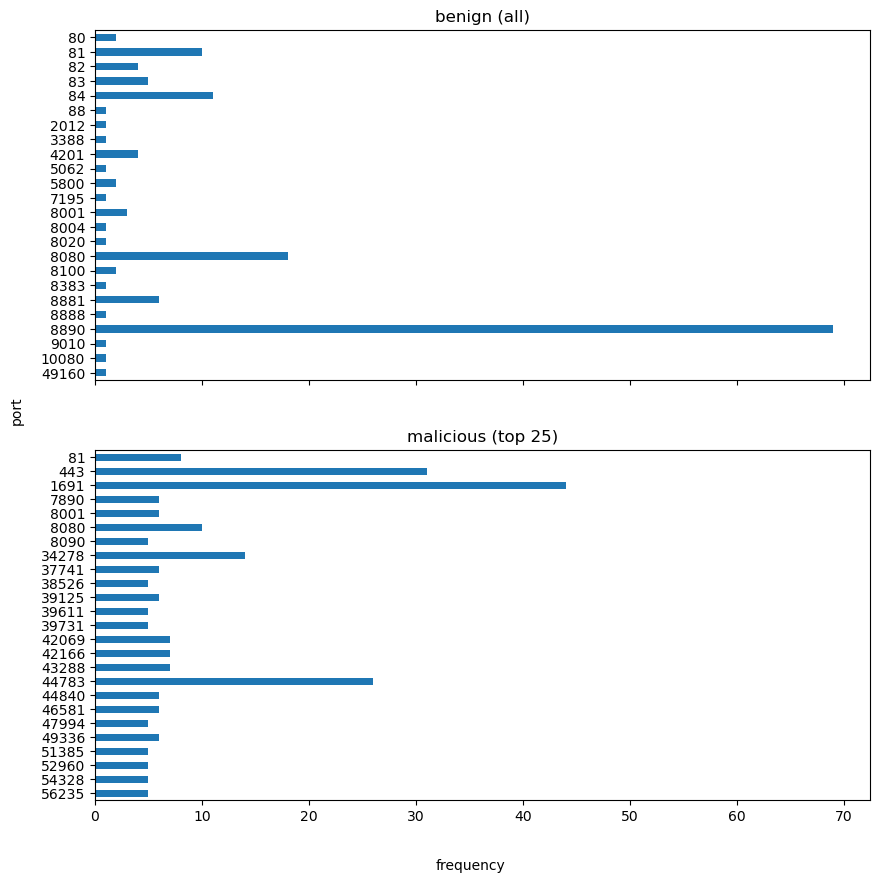

In [20]:
benign = df.query(expr='type == "benign"')['port'].value_counts()
malicious= df.query(expr='type != "benign"')['port'].value_counts()
malicious.drop(malicious.iloc[25:].index, inplace=True)

fig, axs = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
ax1 = axs[0]
ax2 = axs[1]
benign.sort_index(ascending=False).plot.barh(ax=ax1)
ax1.set_title('benign (all)')
malicious.sort_index(ascending=False).plot.barh(ax=ax2)
ax2.set_title('malicious (top 25)')
fig.text(0.5, 0.04, 'frequency', ha='center')
fig.text(0.04, 0.5, 'port', va='center', rotation='vertical')

plt.show()

In [21]:
from urllib.parse import parse_qs

df['query_length'] = df['query'].apply(lambda x: len(str(x)))

df['query_args'] = df['query'].apply(lambda x: len(parse_qs(x)))

In [22]:
from pathlib import Path

df['path_length'] = df['path'].apply(lambda x: len(str(x)))

df['path_depth'] = df['path'].apply(lambda x: len(Path(str(x)).parents))

In [23]:
import ipaddress
import tldextract as tldx

def is_ip(url):
    try:
        ip = ipaddress.ip_address(url)
    except:
        return False
    return str(ip) == url

def count_subdomains(hostname, has_ip):
    if has_ip:
        return 0
    else:
        ext = tldx.extract(hostname)
        return len(ext.subdomain.split('.'))

def extract_tld(hostname, has_ip):
    if has_ip:
        return ''
    else:
        ext = tldx.extract(hostname)
        return ext.suffix
    

df['hostname_length'] = df['hostname'].apply(lambda x: len(str(x)))
df['has_ip'] = df['hostname'].apply(lambda x: 1 if is_ip(str(x)) else 0)
df['num_subdomains'] = df.apply(lambda row: count_subdomains(row['hostname'], row['has_ip']), axis=1)
df['tld'] = df.apply(lambda row: extract_tld(row['hostname'], row['has_ip']), axis=1)

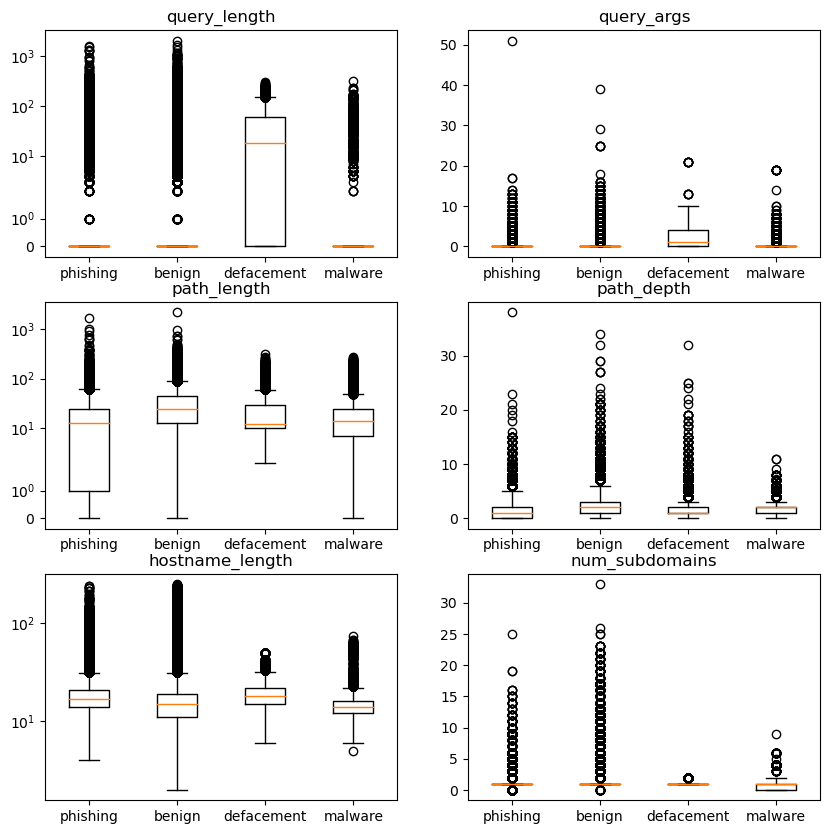

In [24]:
features = ['query_length', 'query_args', 'path_length', 'path_depth', 'hostname_length', 'num_subdomains']

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(10, 10))

for i, feature in enumerate(features):
    row = i // 2
    col = i % 2
    ax = axs[row, col]
    ax.boxplot([df[df['type'] == t][feature] for t in df['type'].unique()])
    ax.set_title(feature)
    ax.set_xticklabels(df['type'].unique())
    if(feature in ['query_length', 'path_length', 'hostname_length']):
        ax.set_yscale('symlog')

plt.show()

In [25]:
df['has_urlencoded_char'] = df['url'].apply(lambda x: 1 if '%' in str(x) else 0)
df['is_abnormal_url'] = df['protocol'].apply(lambda x: 1 if str(x) == '' else 0)
df['has_fragment'] = df['fragment'].apply(lambda x: 1 if str(x) != '' else 0)

In [26]:
# Match URL shorteners
SHORTENERS = 'datasets/shorteners.txt'

with open(SHORTENERS, 'r') as f:
    shorteners = [line.strip() for line in f.readlines()]

df['is_shortener'] = df['hostname'].apply(lambda x: 1 if x in shorteners else 0)

df.query('is_shortener == 1')['url'].count()

1112

In [27]:
# Detect suspicious TLDs
# https://unit42.paloaltonetworks.com/top-level-domains-cybercrime/

SUS_COMMON = 'datasets/suspicious_tlds_common.txt'
SUS_HI_RATE = 'datasets/suspicious_tlds_high_rate.txt'
SENSITIVE = 'datasets/sensitive_tlds.txt'

tlds = dict()
for path in [SUS_COMMON, SUS_HI_RATE, SENSITIVE]:
    with open(path) as f:
        tlds[path] = [line.strip() for line in f.readlines()]

df['has_common_sus_tld'] = df['tld'].apply(lambda x: 1 if x in tlds[SUS_COMMON] else 0)
df['has_hi_rate_sus_tld'] = df['tld'].apply(lambda x: 1 if x in tlds[SUS_HI_RATE] else 0)
df['has_sensitive_tld'] = df['tld'].apply(lambda x: 1 if x in tlds[SENSITIVE] else 0)

print(df.query('has_common_sus_tld == 1')['url'].count())
print(df.query('has_hi_rate_sus_tld == 1')['url'].count())
print(df.query('has_sensitive_tld == 1')['url'].count())

499871
2736
200


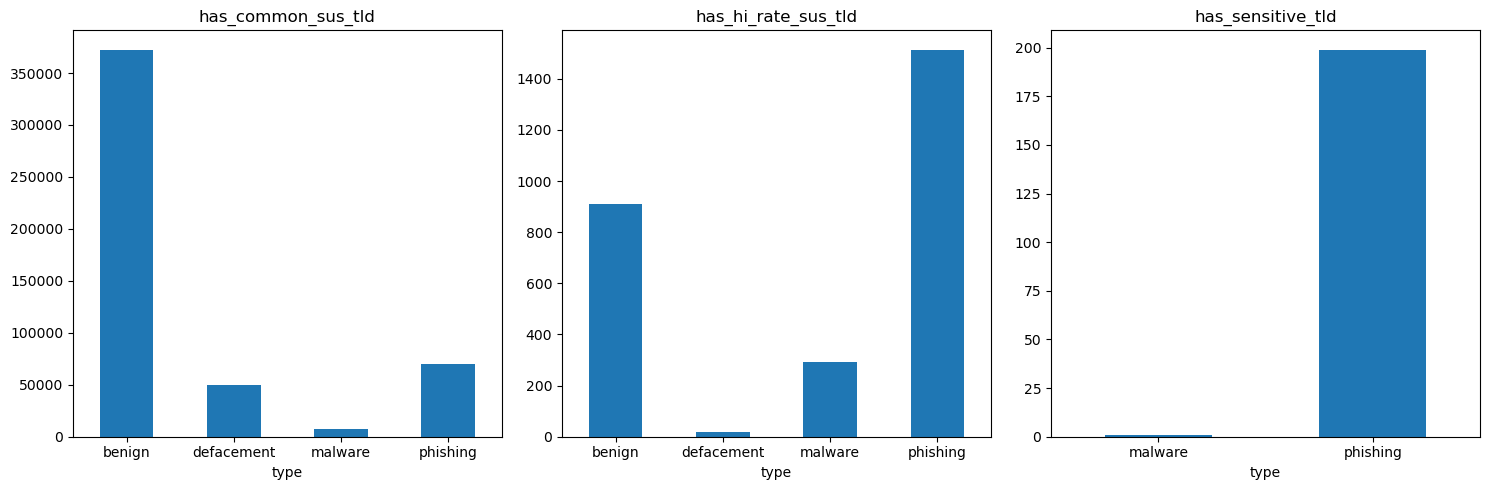

In [28]:
features = ['has_common_sus_tld', 'has_hi_rate_sus_tld', 'has_sensitive_tld']

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
for i, feature in enumerate(features):
    ax = axes[i]
    bars = df[df[feature] == 1].groupby('type')[feature].count().plot.bar(ax=ax, rot=0)
    ax.set_title(feature)

plt.tight_layout()
plt.show()

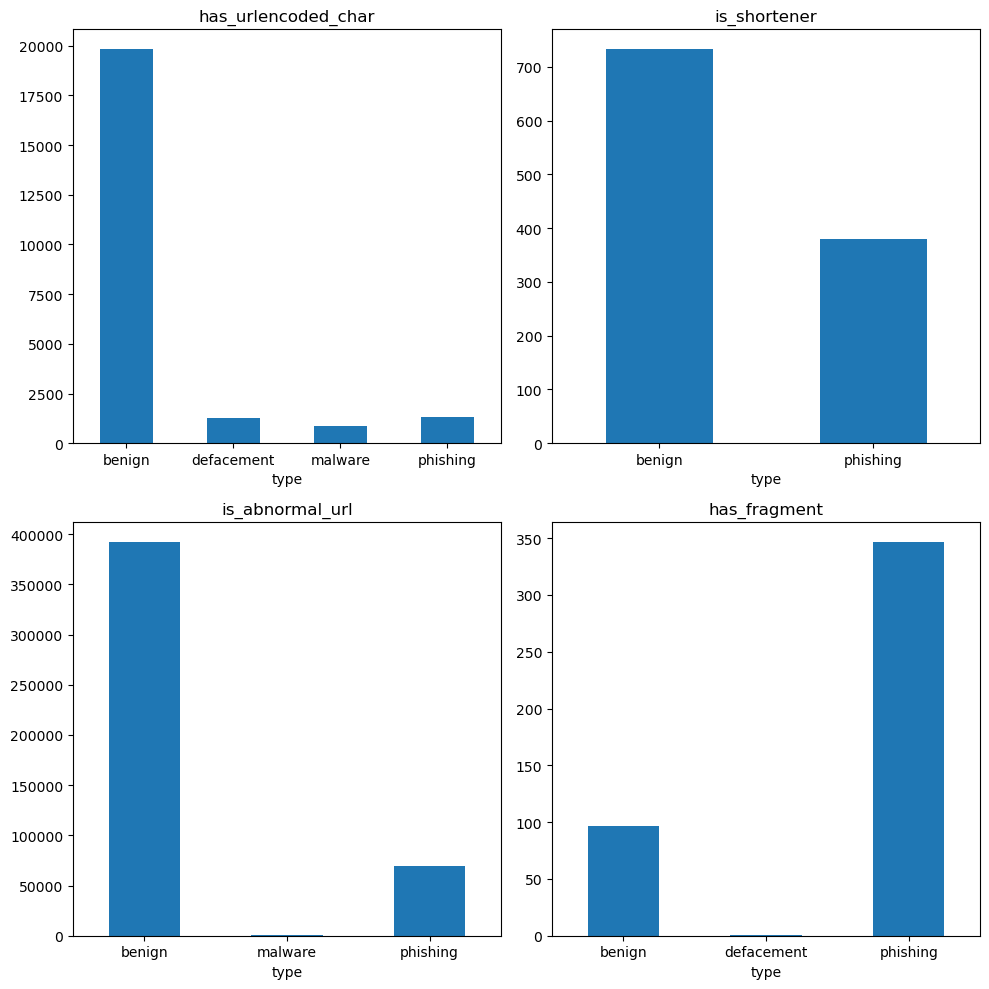

In [29]:
features = ['has_urlencoded_char', 'is_shortener', 'is_abnormal_url', 'has_fragment']

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
for i, feature in enumerate(features):
    row = i // 2
    col = i % 2
    ax = axes[row, col]
    bars = df[df[feature] == 1].groupby('type')[feature].count().plot.bar(ax=ax, rot=0)
    ax.set_title(feature)

plt.tight_layout()
plt.show()

<Axes: >

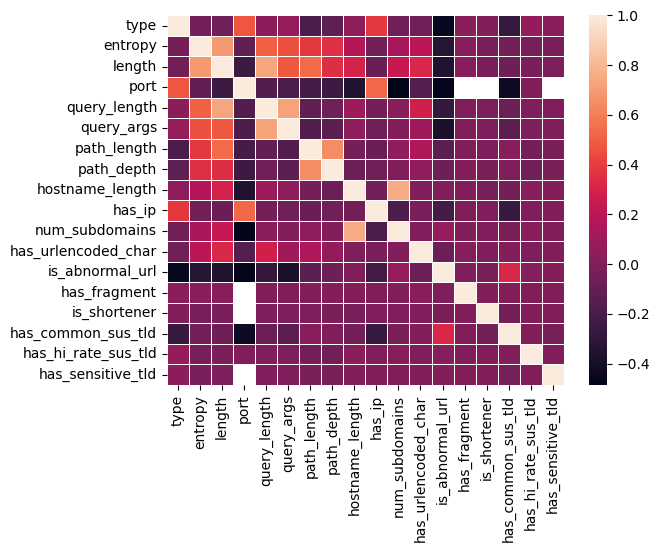

In [30]:
import seaborn as sns

plt.figure()
temp_df = pd.DataFrame(df)
temp_df['type'] = temp_df['type'].apply(lambda x: 1 if x == 'defacement' else 2 if x == 'phishing' else 3 if x == 'malware' else 0)
sns.heatmap(temp_df.corr(numeric_only=True), linewidths=.5)

## Training set

In [31]:
train_Y = df['type'].apply(lambda x: 'malicious' if x != 'benign' else x)
train_x_raw = df.drop(columns=['url', 'type', 'hostname', 'path', 'query', 'fragment', 'tld'])

train_x_raw.describe(include='all')

,encoding,entropy,length,port,protocol,query_length,query_args,path_length,path_depth,hostname_length,has_ip,num_subdomains,has_urlencoded_char,is_abnormal_url,has_fragment,is_shortener,has_common_sus_tld,has_hi_rate_sus_tld,has_sensitive_tld
count,641013,641014.000000,641014.000000,5141.0,641014,641014.000000,641014.000000,641014.000000,641014.000000,641014.000000,641014.000000,641014.000000,641014.000000,641014.000000,641014.000000,641014.000000,641014.000000,641014.000000,641014.000000
unique,7,NaN,NaN,<NA>,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,ascii,NaN,NaN,<NA>,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,640203,NaN,NaN,<NA>,463070,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,4.207812,61.200038,42396.71951,NaN,11.572874,0.544636,28.513716,2.074264,17.405997,0.018917,1.086831,0.036294,0.722402,0.000694,0.001735,0.779813,0.004268,0.000312
std,NaN,0.414325,44.552114,14914.113409,NaN,34.030121,1.361899,27.937355,1.593860,11.351191,0.136232,0.818694,0.187021,0.447814,0.026339,0.041614,0.414373,0.065192,0.017661
min,NaN,1.779908,7.000000,70.0,NaN,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,NaN,3.945465,33.000000,36851.0,NaN,0.000000,0.000000,10.000000,1.000000,12.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,NaN,4.213731,48.000000,45211.0,NaN,0.000000,0.000000,21.000000,2.000000,16.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,NaN,4.482926,78.000000,53106.0,NaN,0.000000,0.000000,39.000000,3.000000,20.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000


In [32]:
col_names = np.array(train_x_raw.columns)

nominal_idx = [np.where(col_names == 'encoding')[0][0], np.where(col_names == 'protocol')[0][0]]
binary_idx = [np.where(col_names == 'has_ip')[0][0], np.where(col_names == 'has_urlencoded_char')[0][0], np.where(col_names == 'is_shortener')[0][0], 
            np.where(col_names == 'is_abnormal_url')[0][0], np.where(col_names == 'has_fragment')[0][0], np.where(col_names == 'has_common_sus_tld')[0][0],
            np.where(col_names == 'has_hi_rate_sus_tld')[0][0], np.where(col_names == 'has_sensitive_tld')[0][0]]
numeric_idx = list(set(range(len(col_names))).difference(nominal_idx).difference(binary_idx))

nominal_cols = col_names[nominal_idx].tolist()
binary_cols = col_names[binary_idx].tolist()
numeric_cols = col_names[numeric_idx].tolist()

print(numeric_cols)
print(binary_cols)
print(nominal_cols)

train_x_raw[binary_cols].describe().transpose()

['entropy', 'length', 'port', 'query_length', 'query_args', 'path_length', 'path_depth', 'hostname_length', 'num_subdomains']
['has_ip', 'has_urlencoded_char', 'is_shortener', 'is_abnormal_url', 'has_fragment', 'has_common_sus_tld', 'has_hi_rate_sus_tld', 'has_sensitive_tld']
['encoding', 'protocol']


,count,mean,std,min,25%,50%,75%,max
has_ip,641014.0,0.018917,0.136232,0.0,0.0,0.0,0.0,1.0
has_urlencoded_char,641014.0,0.036294,0.187021,0.0,0.0,0.0,0.0,1.0
is_shortener,641014.0,0.001735,0.041614,0.0,0.0,0.0,0.0,1.0
is_abnormal_url,641014.0,0.722402,0.447814,0.0,0.0,1.0,1.0,1.0
has_fragment,641014.0,0.000694,0.026339,0.0,0.0,0.0,0.0,1.0
has_common_sus_tld,641014.0,0.779813,0.414373,0.0,1.0,1.0,1.0,1.0
has_hi_rate_sus_tld,641014.0,0.004268,0.065192,0.0,0.0,0.0,0.0,1.0
has_sensitive_tld,641014.0,0.000312,0.017661,0.0,0.0,0.0,0.0,1.0


In [33]:
train_x_raw['port'] = train_x_raw['port'].apply(lambda x: x if pd.notna(x) else 0)

In [34]:
train_x = pd.get_dummies(train_x_raw, columns=nominal_cols, drop_first=True)
dummy_variables = list(set(train_x)-set(train_x_raw))
train_x.describe()

,entropy,length,port,query_length,query_args,path_length,path_depth,hostname_length,has_ip,num_subdomains,...,has_sensitive_tld,encoding_ISO-8859-9,encoding_MacRoman,encoding_Windows-1252,encoding_Windows-1254,encoding_ascii,encoding_utf-8,protocol_ftp,protocol_http,protocol_https
count,641014.000000,641014.000000,641014.000000,641014.000000,641014.000000,641014.000000,641014.000000,641014.000000,641014.000000,641014.000000,...,641014.000000,641014.000000,641014.000000,641014.000000,641014.000000,641014.000000,641014.000000,641014.000000,641014.000000,641014.000000
mean,4.207812,61.200038,340.026169,11.572874,0.544636,28.513716,2.074264,17.405997,0.018917,1.086831,...,0.000312,0.000070,0.000126,0.000064,0.000003,0.998735,0.000939,0.000003,0.253200,0.024394
std,0.414325,44.552114,4010.482861,34.030121,1.361899,27.937355,1.593860,11.351191,0.136232,0.818694,...,0.017661,0.008378,0.011240,0.007997,0.001766,0.035547,0.030631,0.001766,0.434845,0.154270
min,1.779908,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.945465,33.000000,0.000000,0.000000,0.000000,10.000000,1.000000,12.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,4.213731,48.000000,0.000000,0.000000,0.000000,21.000000,2.000000,16.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,4.482926,78.000000,0.000000,0.000000,0.000000,39.000000,3.000000,20.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
max,7.511675,2177.000000,65509.000000,2005.000000,51.000000,2156.000000,38.000000,248.000000,1.000000,33.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Classification

In [35]:
from sklearn.model_selection import StratifiedKFold

K_FOLDS = 10
skf = StratifiedKFold(K_FOLDS, shuffle=True, random_state=42)

In [36]:
def print_metrics(results):
    metrics = ['accuracy','precision', 'recall','f1_score']
    for metric in metrics:
        print(f'{metric:15}', np.round(results["test_"+metric].mean(),3), [np.round(elem,3) for elem in results["test_"+metric]])
    print()
    print(f'{"fit_time":15}', np.round(results["fit_time"].mean()))
    print(f'{"score_time":15}', np.round(results["score_time"].mean()))

In [55]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, recall_score, accuracy_score, f1_score, precision_score

RF_clf = RandomForestClassifier()
RF_cross = cross_validate(RF_clf, train_x, train_Y, scoring={
                                                        'precision': make_scorer(precision_score, pos_label='malicious'),
                                                        'recall': make_scorer(recall_score, pos_label='malicious'),
                                                        'f1_score': make_scorer(f1_score, pos_label='malicious'),
                                                        'accuracy': make_scorer(accuracy_score)},
                        return_estimator=True,
                        cv = skf,
                        n_jobs=-1)
print_metrics(RF_cross)

accuracy        0.928 [0.926, 0.93, 0.928, 0.93, 0.926, 0.928, 0.927, 0.928, 0.93, 0.929]
precision       0.913 [0.912, 0.915, 0.91, 0.914, 0.912, 0.911, 0.913, 0.913, 0.914, 0.915]
recall          0.867 [0.861, 0.87, 0.868, 0.872, 0.862, 0.868, 0.862, 0.867, 0.87, 0.868]
f1_score        0.889 [0.886, 0.892, 0.888, 0.892, 0.886, 0.889, 0.887, 0.889, 0.891, 0.891]

fit_time        74.0
score_time      2.0


In [56]:
from sklearn.tree import DecisionTreeClassifier

DT_clf = DecisionTreeClassifier()
DT_cross = cross_validate(DT_clf, train_x, train_Y, scoring={
                                                        'precision': make_scorer(precision_score, pos_label='malicious'),
                                                        'recall': make_scorer(recall_score, pos_label='malicious'),
                                                        'f1_score': make_scorer(f1_score, pos_label='malicious'),
                                                        'accuracy': make_scorer(accuracy_score)},
                        return_estimator=True,
                        cv = skf,
                        n_jobs=-1)
print_metrics(DT_cross)

accuracy        0.918 [0.916, 0.919, 0.918, 0.919, 0.916, 0.919, 0.917, 0.919, 0.919, 0.919]
precision       0.886 [0.886, 0.886, 0.884, 0.887, 0.884, 0.887, 0.886, 0.888, 0.887, 0.888]
recall          0.864 [0.857, 0.868, 0.867, 0.865, 0.86, 0.865, 0.86, 0.865, 0.867, 0.865]
f1_score        0.875 [0.871, 0.877, 0.875, 0.876, 0.872, 0.876, 0.873, 0.876, 0.877, 0.876]

fit_time        3.0
score_time      1.0


In [57]:
from sklearn.naive_bayes import GaussianNB

NB_clf = GaussianNB()
NB_cross = cross_validate(NB_clf, train_x, train_Y, scoring={
                                                        'precision': make_scorer(precision_score, pos_label='malicious'),
                                                        'recall': make_scorer(recall_score, pos_label='malicious'),
                                                        'f1_score': make_scorer(f1_score, pos_label='malicious'),
                                                        'accuracy': make_scorer(accuracy_score)},
                        return_estimator=True,
                        cv = skf,
                        n_jobs=-1)
print_metrics(NB_cross)

accuracy        0.845 [0.842, 0.846, 0.845, 0.847, 0.846, 0.843, 0.844, 0.844, 0.845, 0.844]
precision       0.883 [0.877, 0.885, 0.878, 0.889, 0.888, 0.884, 0.883, 0.88, 0.883, 0.883]
recall          0.613 [0.61, 0.615, 0.62, 0.615, 0.615, 0.607, 0.611, 0.614, 0.616, 0.612]
f1_score        0.724 [0.72, 0.726, 0.727, 0.727, 0.727, 0.72, 0.722, 0.723, 0.726, 0.723]

fit_time        1.0
score_time      1.0


In [58]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

MLP_pipe = Pipeline([('vect', StandardScaler()), ('clf', MLPClassifier())])
MLP_cross = cross_validate(MLP_pipe, train_x, train_Y, scoring={
                                                        'precision': make_scorer(precision_score, pos_label='malicious'),
                                                        'recall': make_scorer(recall_score, pos_label='malicious'),
                                                        'f1_score': make_scorer(f1_score, pos_label='malicious'),
                                                        'accuracy': make_scorer(accuracy_score)},
                        return_estimator=True,
                        cv = skf,
                        n_jobs=-1)
print_metrics(MLP_cross)

accuracy        0.929 [0.928, 0.93, 0.93, 0.93, 0.929, 0.929, 0.928, 0.929, 0.93, 0.931]
precision       0.96 [0.973, 0.939, 0.974, 0.972, 0.97, 0.964, 0.953, 0.946, 0.952, 0.958]
recall          0.822 [0.806, 0.844, 0.811, 0.814, 0.811, 0.817, 0.825, 0.833, 0.831, 0.827]
f1_score        0.886 [0.882, 0.889, 0.886, 0.886, 0.883, 0.885, 0.885, 0.886, 0.887, 0.888]

fit_time        143.0
score_time      1.0


In [59]:
from sklearn.linear_model import SGDClassifier
from sklearn.kernel_approximation import RBFSampler

SGD_pipe = Pipeline([('vect', StandardScaler()), ('rbf', RBFSampler()), ('clf', SGDClassifier())])
SGD_cross = cross_validate(SGD_pipe, train_x, train_Y, scoring={
                                                        'precision': make_scorer(precision_score, pos_label='malicious'),
                                                        'recall': make_scorer(recall_score, pos_label='malicious'),
                                                        'f1_score': make_scorer(f1_score, pos_label='malicious'),
                                                        'accuracy': make_scorer(accuracy_score)},
                        return_estimator=True,
                        cv = skf,
                        n_jobs=-1)
print_metrics(SGD_cross)

accuracy        0.803 [0.809, 0.806, 0.822, 0.802, 0.8, 0.794, 0.803, 0.797, 0.798, 0.798]
precision       0.794 [0.773, 0.807, 0.803, 0.816, 0.802, 0.805, 0.806, 0.755, 0.799, 0.772]
recall          0.55 [0.601, 0.546, 0.615, 0.523, 0.529, 0.5, 0.534, 0.574, 0.525, 0.554]
f1_score        0.649 [0.676, 0.651, 0.696, 0.637, 0.637, 0.617, 0.643, 0.652, 0.633, 0.645]

fit_time        5.0
score_time      1.0


<Axes: >

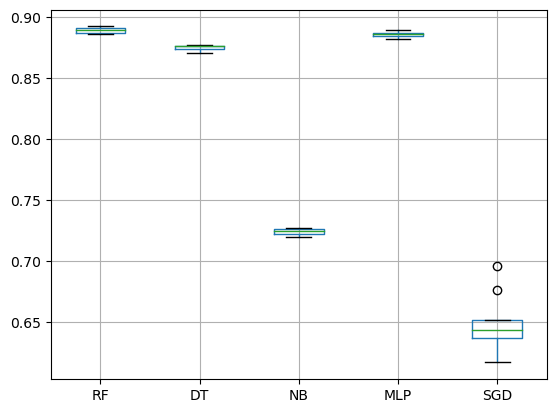

In [60]:
f_score = pd.DataFrame({'RF':RF_cross['test_f1_score'], 'DT': DT_cross['test_f1_score'], 'NB':NB_cross['test_f1_score'], 'MLP':MLP_cross['test_f1_score'], 'SGD':SGD_cross['test_f1_score']})
f_score.boxplot()

In [61]:
from scipy.stats import wilcoxon
wilcoxon(f_score.RF,f_score.DT)

WilcoxonResult(statistic=0.0, pvalue=0.001953125)

## TODO

- better boxplot for all metrics
- better organization of wilcoxon test results in a matrix for display
- try again by doing undersampling
- try again by doing multilclass

### Didn't do

- Detect base 64/hex (too hard)
- Detect homographs (didn't find any in the dataset)
- Detect "spoofed" hostnames in other parts of the URL (hard to match, found only one)
- Match specific words (admin, login, password...) OR do stemming